<a href="https://colab.research.google.com/github/shadowscythe03/es335-24-fall-assignment-2/blob/master/Task_2_image_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image reconstruction using RFF features and Linear regression:

For GPU, write .to(device) else just remove all of it

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
if os.path.exists("/content/road-8284023_1280.jpg"):
  print("Image is at this path: /content/road-8284023_1280.jpg")

Image is at this path: /content/road-8284023_1280.jpg


In [ ]:
img = torchvision.io.read_image("/content/road-8284023_1280.jpg")
print(img.shape)

torch.Size([3, 1280, 852])


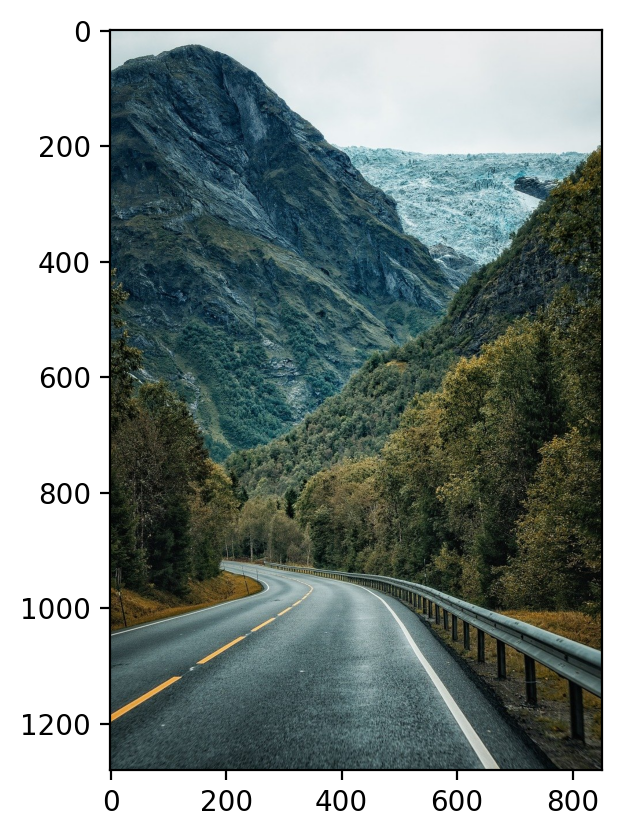

In [ ]:
plt.imshow(rearrange(img, 'b h w -> h w b').numpy())

In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)) #converts to 1D array of 3*h*w 3 is channels
img_scaled = img_scaled.reshape(img.shape)

img_scaled = torch.tensor(img_scaled)
img_scaled.shape

torch.Size([3, 1280, 852])

In [ ]:
cropped_image = torchvision.transforms.functional.crop(img_scaled.cpu(), 200, 400, 300, 300)
cropped_image.to(device)
cropped_image.shape

torch.Size([3, 300, 300])

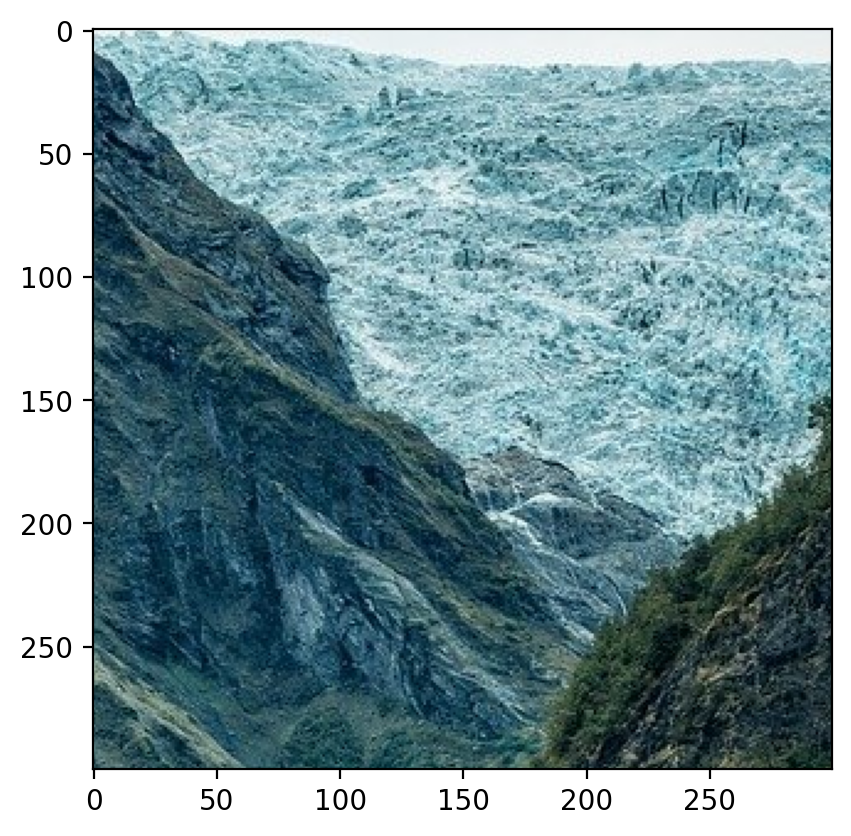

In [ ]:
plt.imshow(rearrange(cropped_image, 'c h w -> h w c').cpu().numpy())

In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).to(torch.float32)

    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').to(torch.float32)
    return X, Y

In [ ]:
road_X, road_Y = create_coordinate_map(cropped_image)
road_X.shape, road_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [ ]:
#Comment for CPU:
road_Y = torch.tensor(road_Y).to(device) #delete for gpu

road_X is (X,Y) vales. road_Y is (no.of (X,Y),channels)

In [ ]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(road_X.cpu())  #road_X will work for GPU, but sklearn is for cpu
road_X_scaled = scaler_X.transform(road_X.cpu())
road_X_scaled = torch.tensor(road_X_scaled).to(device)

# Set to dtype float32
road_X_scaled = road_X_scaled.to(torch.float32)

In [ ]:
road_X_scaled[59909:59919]

tensor([[0.3311, 0.3980],
        [0.3311, 0.4047],
        [0.3311, 0.4114],
        [0.3311, 0.4181],
        [0.3311, 0.4247],
        [0.3311, 0.4314],
        [0.3311, 0.4381],
        [0.3311, 0.4448],
        [0.3311, 0.4515],
        [0.3311, 0.4582]], device='cuda:0')

In [ ]:
road_Y[59909:59919]

tensor([[0.2118, 0.3608, 0.4039],
        [0.2941, 0.4431, 0.4863],
        [0.3333, 0.4824, 0.5255],
        [0.2431, 0.3922, 0.4353],
        [0.1412, 0.2902, 0.3255],
        [0.3451, 0.4941, 0.5373],
        [0.3961, 0.5451, 0.5804],
        [0.3686, 0.5098, 0.5569],
        [0.1373, 0.2784, 0.3255],
        [0.1686, 0.3098, 0.3569]], device='cuda:0')

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ##Now plotting for original image

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2)
    degree: int

    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    X1 = X[:, 0]  #1st column or feature
    X2 = X[:, 1]  #2nd column or feature

    X1 = X1.unsqueeze(1)  #making it in shape of (90000,1)
    X2 = X2.unsqueeze(1)
    X = torch.cat([X1, X2], dim=1)  #Concatenating along column

    poly = preprocessing.PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X.cpu())

    return torch.tensor(X, dtype=torch.float32).to(device)

In [ ]:
road_X_scaled_poly = poly_features(road_X_scaled, 50)
road_X_scaled_poly.dtype, road_X_scaled_poly.shape, road_Y.shape, road_Y.dtype

(torch.float32,
 torch.Size([90000, 1326]),
 torch.Size([90000, 3]),
 torch.float32)

In [ ]:
net = LinearModel(road_X_scaled_poly.shape[1], 3)
net.to(device)

train(net, 0.005, road_X_scaled_poly, road_Y, 1500)

Epoch 0 loss: 0.250839
Epoch 100 loss: 0.026806
Epoch 200 loss: 0.023363
Epoch 300 loss: 0.022243
Epoch 400 loss: 0.021698
Epoch 500 loss: 0.021378
Epoch 600 loss: 0.021156
Epoch 700 loss: 0.020988
Epoch 800 loss: 0.020853
Epoch 900 loss: 0.020729
Epoch 1000 loss: 0.020627
Epoch 1100 loss: 0.020541
Epoch 1200 loss: 0.020462
Epoch 1300 loss: 0.020393
Epoch 1400 loss: 0.020330


0.020274536684155464

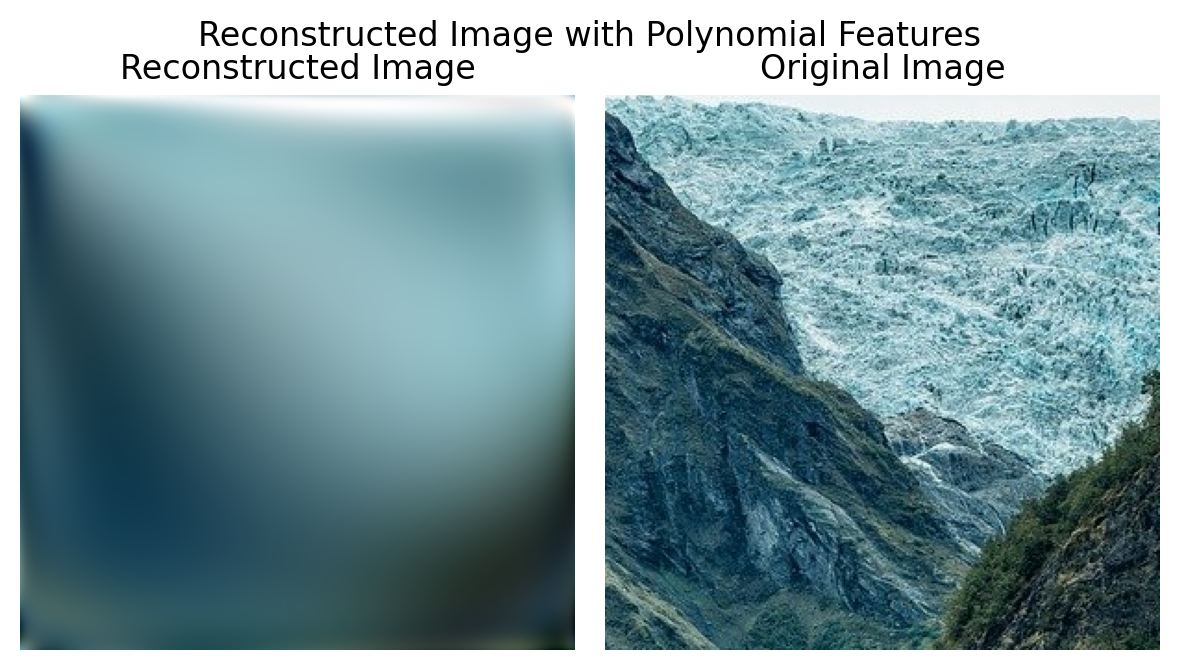

In [ ]:
plot_reconstructed_and_original_image(cropped_image, net, road_X_scaled_poly, title="Reconstructed Image with Polynomial Features")

Creating RFF features

In [ ]:
def create_rff_features(X, num_features, sigma, device, batch_size=5000):
    n_samples, n_features = X.shape

    # Generate random weights and bias for RFF (weights can be large, so precompute and store on GPU)
    W = torch.randn(n_features, num_features, device=device) / sigma  # Random Gaussian weights
    b = 2 * torch.pi * torch.rand(num_features, device=device)  # Random bias

    Z_list = []  # Store the chunks of transformed data

    # Process the input in smaller batches to reduce memory usage
    for i in range(0, n_samples, batch_size):
        X_batch = X[i:i + batch_size]  # Slice the batch from the input tensor
        Z_batch = torch.matmul(X_batch, W) + b  # Linear transformation
        Z_batch = torch.cos(Z_batch) * (2.0 / torch.sqrt(torch.tensor(num_features, dtype=torch.float32, device=device)))  # Apply cosine and normalize
        Z_list.append(Z_batch)

    # Concatenate all the processed batches to form the final tensor
    Z = torch.cat(Z_list, dim=0)

    return Z

In [ ]:
X_rff = create_rff_features(road_X_scaled, 10000, 0.008, device)

In [ ]:
net = LinearModel(X_rff.shape[1], 3)    #same as 2, 3 only
net.to(device)

train(net, 0.005, X_rff, road_Y, 2500)

Epoch 0 loss: 0.275650
Epoch 100 loss: 0.056519
Epoch 200 loss: 0.041785
Epoch 300 loss: 0.037778
Epoch 400 loss: 0.034985
Epoch 500 loss: 0.032765
Epoch 600 loss: 0.030884
Epoch 700 loss: 0.029239
Epoch 800 loss: 0.027775
Epoch 900 loss: 0.026461
Epoch 1000 loss: 0.025273
Epoch 1100 loss: 0.024195
Epoch 1200 loss: 0.023214
Epoch 1300 loss: 0.022318
Epoch 1400 loss: 0.021498
Epoch 1500 loss: 0.020747
Epoch 1600 loss: 0.020058
Epoch 1700 loss: 0.019425
Epoch 1800 loss: 0.018843
Epoch 1900 loss: 0.018309
Epoch 2000 loss: 0.017817
Epoch 2100 loss: 0.017366
Epoch 2200 loss: 0.016950
Epoch 2300 loss: 0.016569
Epoch 2400 loss: 0.016218


0.015898382291197777

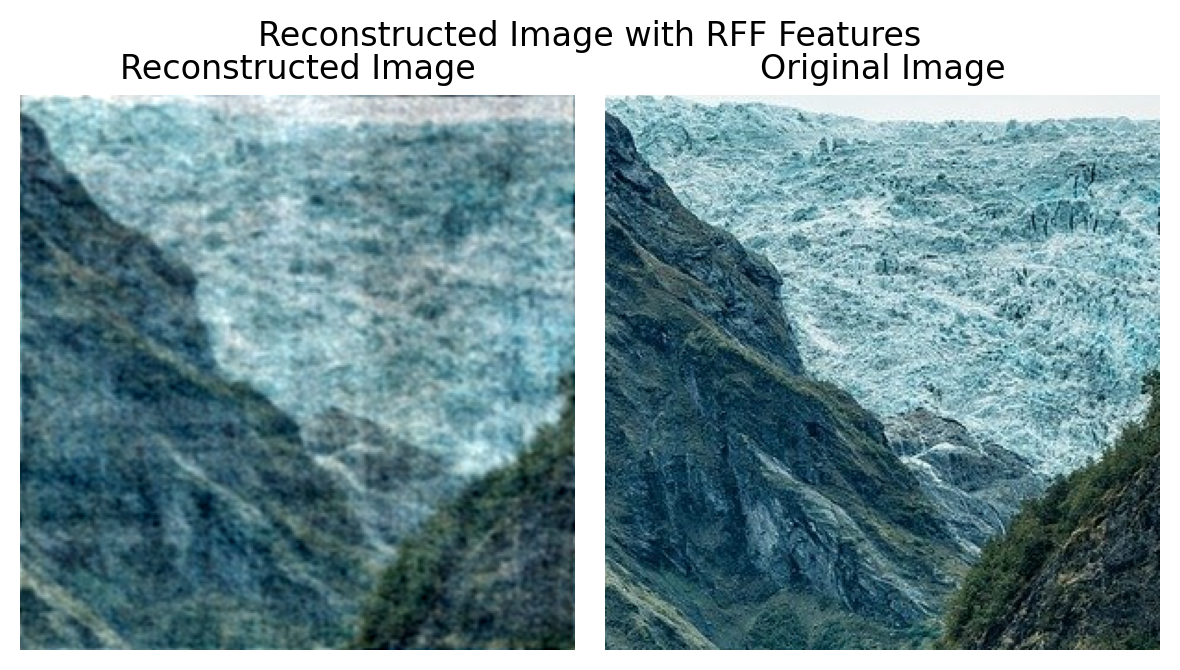

In [ ]:
plot_reconstructed_and_original_image(cropped_image, net, X_rff, title="Reconstructed Image with RFF Features")

In [ ]:
num_channels, height, width = cropped_image.shape
net.eval()
with torch.no_grad():
    outputs = net(X_rff)
    outputs = outputs.reshape(height, width, num_channels)
fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
print("Reconstructed pixels:\n",outputs), print("\n\nOriginal pixels\n",cropped_image)

Reconstructed pixels:
 tensor([[[0.7037, 0.7109, 0.7031],
         [0.7911, 0.8173, 0.8205],
         [0.8420, 0.8789, 0.8862],
         ...,
         [0.7655, 0.8138, 0.8168],
         [0.7452, 0.8083, 0.8163],
         [0.5991, 0.7024, 0.7239]],

        [[0.7234, 0.7501, 0.7509],
         [0.8480, 0.8879, 0.8974],
         [0.8989, 0.9461, 0.9589],
         ...,
         [0.8585, 0.8857, 0.8917],
         [0.8418, 0.8783, 0.8885],
         [0.6289, 0.7045, 0.7286]],

        [[0.6582, 0.7008, 0.7058],
         [0.7919, 0.8466, 0.8607],
         [0.8459, 0.9101, 0.9269],
         ...,
         [0.8730, 0.8952, 0.8993],
         [0.8286, 0.8583, 0.8679],
         [0.5824, 0.6496, 0.6756]],

        ...,

        [[0.2608, 0.3679, 0.3908],
         [0.2528, 0.3770, 0.3993],
         [0.2764, 0.4036, 0.4240],
         ...,
         [0.1519, 0.2296, 0.1839],
         [0.1412, 0.2136, 0.1626],
         [0.1358, 0.2199, 0.1605]],

        [[0.2881, 0.3818, 0.3979],
         [0.2409, 0.3613

(None, None)

<Figure size 600x400 with 0 Axes>

In [ ]:
cropped_image_rearranged = cropped_image.permute(1, 2, 0).to(device)
print(cropped_image_rearranged.shape)
print(outputs.shape)

torch.Size([300, 300, 3])
torch.Size([300, 300, 3])


In [ ]:
def compute_rmse(tensor1, tensor2):
    # Ensure both tensors are on the same device (GPU)
    assert tensor1.shape == tensor2.shape, "Tensors must have the same shape"

    mse = torch.mean((tensor1 - tensor2) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def compute_psnr(tensor1, tensor2, max_pixel_value=1.0):
    mse = torch.mean((tensor1 - tensor2) ** 2)
    psnr = 10 * torch.log10(max_pixel_value ** 2 / mse)
    return psnr.item()

In [ ]:
rmse = compute_rmse(cropped_image_rearranged, outputs)
psnr = compute_psnr(cropped_image_rearranged, outputs)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr}")

RMSE: 0.12607652230018154
PSNR: 17.98731558571213
